# 🚀 PHASE 4: ADVANCED MODEL OPTIMIZATION & PRODUCTION PIPELINE

**Building on Phase 3 Success**: XGBoost R² = 0.927, RMSE = 2.25 years  
**Goal**: Achieve R² > 0.93 and create production-ready pipeline

## 📋 Phase 4 Roadmap
- **4A**: Hyperparameter Optimization & Advanced Models
- **4B**: Robust Cross-Validation Framework  
- **4C**: Ensemble & Meta-Learning
- **4D**: Advanced Model Interpretation (SHAP)
- **4E**: Production Pipeline Development

---


# 🚀 PHASE 4: ADVANCED MODEL OPTIMIZATION & PRODUCTION PIPELINE

**Building on Phase 3 Success**: XGBoost R² = 0.927, RMSE = 2.25 years  
**Goal**: Achieve R² > 0.93 and create production-ready pipeline

## 📋 Phase 4 Roadmap
- **4A**: Hyperparameter Optimization & Advanced Models
- **4B**: Robust Cross-Validation Framework  
- **4C**: Ensemble & Meta-Learning
- **4D**: Advanced Model Interpretation (SHAP)
- **4E**: Production Pipeline Development

---


In [2]:

# PHASE 4: ADVANCED MODEL OPTIMIZATION - IMPORTS & SETUP



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - Core
from sklearn.model_selection import (
    train_test_split, cross_val_score, TimeSeriesSplit,
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    VotingRegressor, StackingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Advanced Models
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
import optuna


# Model Interpretation
import shap


# Model Tracking & Deployment
import mlflow
import mlflow.sklearn


# Visualization Setup
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Random State for Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Session started: 2025-09-23 10:19:31


## Data Loading & Phase 3 Results Review


In [3]:
# Load the processed dataset from Phase 2A
df = pd.read_csv('../data/Life_Expectancy_Processed.csv')

# Data Overview
print(f"Time period: {df['Year'].min()}-{df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")
print(f"Missing values in target: {df['Life expectancy'].isnull().sum()}")

# Remove rows with missing target variable
df_clean = df.dropna(subset=['Life expectancy']).copy()
print(f"Clean dataset: {df_clean.shape[0]} samples")

# Feature Selection (from Phase 3 analysis)
exclude_cols = ['Country', 'Year', 'Life expectancy']
available_features = [col for col in df_clean.columns if col not in exclude_cols]

print(f"\nFeature categories:")
tier1_features = ['Schooling', 'Adult Mortality', 'HIV/AIDS']
tier2_features = ['Income composition of resources', 'BMI', 'GDP']
engineered_features = [col for col in available_features if '_Index' in col or 'Region_' in col]
other_features = [col for col in available_features if col not in tier1_features + tier2_features + engineered_features]

print(f"  Tier 1 (Top predictors): {len(tier1_features)}")
print(f"  Tier 2 (Strong predictors): {len(tier2_features)}")
print(f"  Engineered features: {len(engineered_features)}")
print(f"  Additional features: {len(other_features)}")

# Prepare features and target
X = df_clean[available_features]
y = df_clean['Life expectancy']

print(f"\nFinal modeling dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target variable range: {y.min():.1f} - {y.max():.1f} years")

# Phase 3 Baseline Results (for reference)

print("PHASE 3 BASELINE RESULTS (TO BEAT):")

phase3_results = {
    'XGBoost': {'R²': 0.927, 'RMSE': 2.25},
    'Random Forest': {'R²': 0.924, 'RMSE': 2.30},
    'LightGBM': {'R²': 0.922, 'RMSE': 2.33},
    'Neural Network': {'R²': 0.899, 'RMSE': 2.65}
}

for model, metrics in phase3_results.items():
    print(f"  {model:<15}: R² = {metrics['R²']:.3f}, RMSE = {metrics['RMSE']:.2f}")

baseline_r2 = 0.927
baseline_rmse = 2.25
print(f"\nTARGET: R² > {baseline_r2:.3f}, RMSE < {baseline_rmse:.2f}")



Time period: 2000-2015
Countries: 193
Missing values in target: 10
Clean dataset: 2928 samples

Feature categories:
  Tier 1 (Top predictors): 3
  Tier 2 (Strong predictors): 3
  Engineered features: 8
  Additional features: 8

Final modeling dataset: 2928 samples, 22 features
Target variable range: 36.3 - 89.0 years
PHASE 3 BASELINE RESULTS (TO BEAT):
  XGBoost        : R² = 0.927, RMSE = 2.25
  Random Forest  : R² = 0.924, RMSE = 2.30
  LightGBM       : R² = 0.922, RMSE = 2.33
  Neural Network : R² = 0.899, RMSE = 2.65

TARGET: R² > 0.927, RMSE < 2.25


## Temporal Train/Test Split


In [9]:
# Temporal split: 2000-2012 for training, 2013-2015 for testing
train_mask = df_clean['Year'] <= 2012
test_mask = df_clean['Year'] >= 2013

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]


categorical_columns = ['Status', 'Region']  # or use: X_train.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col in X_train.columns:
        # Convert to categorical codes
        X_train[col] = pd.Categorical(X_train[col]).codes
        X_test[col] = pd.Categorical(X_test[col]).codes
        X[col] = pd.Categorical(X[col]).codes  # Also convert the main X dataframe

print(f"✅ Converted categorical columns: {categorical_columns}")
print(f"New dtypes: {X_train[categorical_columns].dtypes.to_dict()}")

print(f"Training set: {len(X_train)} samples (2000-2012)")
print(f"Test set: {len(X_test)} samples (2013-2015)")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.1f}:1")

# Target distribution comparison
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Check for data leakage
train_countries = set(df_clean[train_mask]['Country'].unique())
test_countries = set(df_clean[test_mask]['Country'].unique())
overlap = len(train_countries & test_countries)
print(f"\nCountry overlap (expected): {overlap}/{len(test_countries)} countries")



✅ Converted categorical columns: ['Status', 'Region']
New dtypes: {'Status': dtype('int8'), 'Region': dtype('int8')}
Training set: 2379 samples (2000-2012)
Test set: 549 samples (2013-2015)
Train/Test ratio: 4.3:1

Target distribution:
  Train - Mean: 68.71, Std: 9.70
  Test  - Mean: 71.46, Std: 8.35

Country overlap (expected): 183/183 countries


# Phase 4A: Hyperparameter Optimization & Advanced Models


In [11]:
# Model configurations for optimization
optimization_results = {}

# 1. XGBOOST OPTIMIZATION (Our current best model)

print("\n1. XGBoost Hyperparameter Optimization")

# Before the optimization, convert object columns to numeric
categorical_columns = X_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_train[col] = pd.Categorical(X_train[col]).codes
    X_test[col] = pd.Categorical(X_test[col]).codes

# Bayesian optimization with Optuna
def xgb_objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': RANDOM_STATE
    }
        
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()
    
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=50)
    
best_xgb_params = study.best_params
best_xgb_score = study.best_value
print(f"   Best CV Score: {best_xgb_score:.4f}")



# Train optimized XGBoost
optimized_xgb = xgb.XGBRegressor(**best_xgb_params, random_state=RANDOM_STATE)
optimized_xgb.fit(X_train, y_train)

# Evaluate on test set
xgb_pred = optimized_xgb.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

optimization_results['Optimized XGBoost'] = {
    'model': optimized_xgb,
    'params': best_xgb_params,
    'cv_score': best_xgb_score,
    'test_r2': xgb_r2,
    'test_rmse': xgb_rmse,
    'predictions': xgb_pred
}

print(f"   Test R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.3f}")
improvement = xgb_r2 - baseline_r2
print(f"   Improvement: {improvement:+.4f} R² points")


[I 2025-09-23 10:35:34,779] A new study created in memory with name: no-name-b0ba39d5-69a3-4d2e-b898-f468e609c938



1. XGBoost Hyperparameter Optimization


[I 2025-09-23 10:35:35,854] Trial 0 finished with value: 0.9104124981349629 and parameters: {'n_estimators': 361, 'max_depth': 4, 'learning_rate': 0.1592768625949422, 'subsample': 0.7896457575615389, 'colsample_bytree': 0.9957736814876363, 'reg_alpha': 8.996046185842555, 'reg_lambda': 8.910853283660643}. Best is trial 0 with value: 0.9104124981349629.
[I 2025-09-23 10:35:36,388] Trial 1 finished with value: 0.9064194120119218 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.2758628926229156, 'subsample': 0.8843066675524396, 'colsample_bytree': 0.9922820709229048, 'reg_alpha': 6.863644726691048, 'reg_lambda': 6.388467051384051}. Best is trial 0 with value: 0.9104124981349629.
[I 2025-09-23 10:35:38,688] Trial 2 finished with value: 0.8985093675488715 and parameters: {'n_estimators': 342, 'max_depth': 9, 'learning_rate': 0.18520871919714288, 'subsample': 0.8056493584495252, 'colsample_bytree': 0.805851208797529, 'reg_alpha': 3.3977537357037493, 'reg_lambda': 6.509

   Best CV Score: 0.9205
   Test R²: 0.9308, RMSE: 2.195
   Improvement: +0.0038 R² points


# Phase 4B: Advanced Cross-Validation Framework


Best optimized model for validation: Optimized XGBoost
Test R²: 0.9308

1. Temporal Cross-Validation (Rolling Window)
   2000-2007 → 2008: R² = 0.9564
   2001-2008 → 2009: R² = 0.9411
   2002-2009 → 2010: R² = 0.9361
   2003-2010 → 2011: R² = 0.9547
   2004-2011 → 2012: R² = 0.9545
   Mean R²: 0.9486 ± 0.0083

2. Geographical Cross-Validation (Leave-One-Region-Out)
   Without Asia           : R² = 0.8032 (n=468)
   Without Europe         : R² = 0.5537 (n=403)
   Without Africa         : R² = 0.5128 (n=403)
   Without Other/Oceania  : R² = 0.8073 (n=793)
   Without Americas       : R² = 0.4004 (n=312)
   Mean R²: 0.6155 ± 0.1629

3. Development Status Cross-Validation
   Train Developing → Test Developed : R² = 0.5635
   Train Developed  → Test Developing: R² = -1.2056
   Mean R²: -0.3210 ± 0.8845

4. Stratified K-Fold (By Life Expectancy Ranges)
   Fold 1: R² = 0.9602
   Fold 2: R² = 0.9574
   Fold 3: R² = 0.9630
   Fold 4: R² = 0.9679
   Fold 5: R² = 0.9612
   Mean R²: 0.9619 ± 0.0035

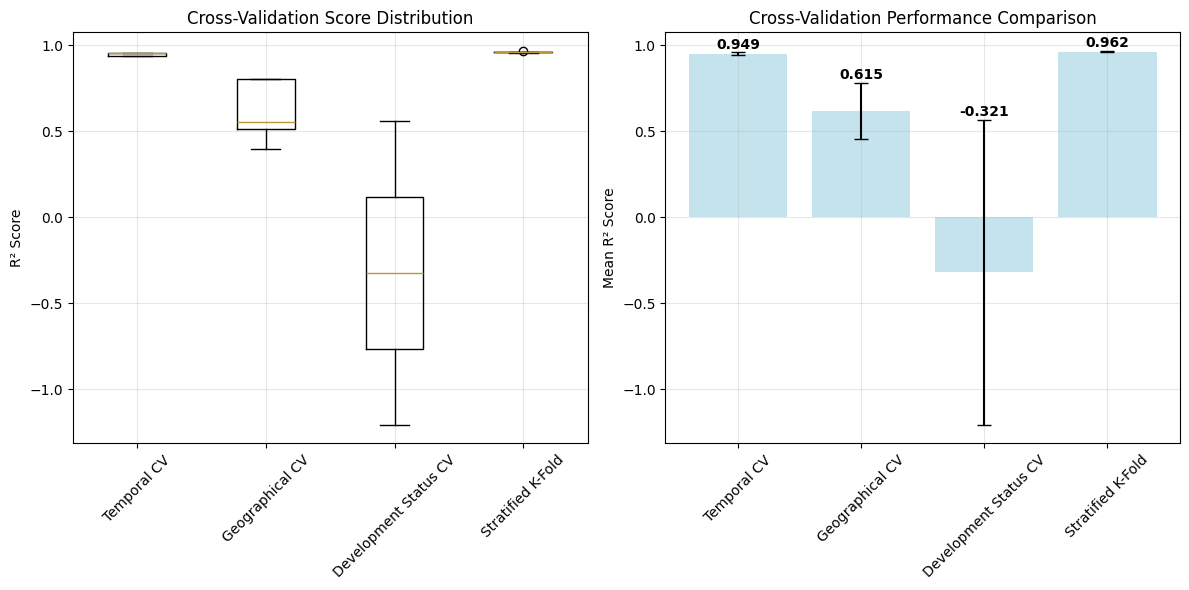

In [12]:
# Get best model from Phase 4A for validation
best_optimized_name = max(optimization_results.keys(), 
                         key=lambda x: optimization_results[x]['test_r2'])
best_optimized_model = optimization_results[best_optimized_name]['model']
print(f"Best optimized model for validation: {best_optimized_name}")
print(f"Test R²: {optimization_results[best_optimized_name]['test_r2']:.4f}")

cv_results = {}


# 1. TEMPORAL CROSS-VALIDATION (Rolling Window)

print("\n1. Temporal Cross-Validation (Rolling Window)")

# Create temporal splits based on years
years = sorted(df_clean['Year'].unique())
temporal_scores = []


# Rolling window: use 8 years for training, 1 year for validation
window_size = 8
for i in range(len(years) - window_size):
    train_years = years[i:i+window_size]
    test_year = years[i+window_size]
    
    # Only validate within training period (before 2013)
    if test_year > 2012:
        break
        
    train_mask = df_clean['Year'].isin(train_years)
    test_mask = df_clean['Year'] == test_year
    
    X_cv_train = X[train_mask]
    y_cv_train = y[train_mask]
    X_cv_test = X[test_mask]
    y_cv_test = y[test_mask]
    
    if len(X_cv_test) > 0:
        # Clone and train model
        temp_model = type(best_optimized_model)(**best_optimized_model.get_params())
        temp_model.fit(X_cv_train, y_cv_train)
        pred = temp_model.predict(X_cv_test)
        score = r2_score(y_cv_test, pred)
        temporal_scores.append(score)
        print(f"   {train_years[0]}-{train_years[-1]} → {test_year}: R² = {score:.4f}")

temporal_mean = np.mean(temporal_scores) if temporal_scores else 0
temporal_std = np.std(temporal_scores) if temporal_scores else 0
cv_results['Temporal CV'] = {
    'scores': temporal_scores,
    'mean': temporal_mean,
    'std': temporal_std
}

print(f"   Mean R²: {temporal_mean:.4f} ± {temporal_std:.4f}")


print("\n2. Geographical Cross-Validation (Leave-One-Region-Out)")


# Get regions from the dataset
regions = df_clean['Region'].unique()
geo_scores = []

for region in regions:
    # Train on all regions except one, test on the left-out region
    train_mask = (df_clean['Region'] != region) & (df_clean['Year'] <= 2012)
    test_mask = (df_clean['Region'] == region) & (df_clean['Year'] <= 2012)
    
    X_geo_train = X[train_mask]
    y_geo_train = y[train_mask]
    X_geo_test = X[test_mask]
    y_geo_test = y[test_mask]
    
    if len(X_geo_test) > 10:  # Ensure sufficient test samples
        temp_model = type(best_optimized_model)(**best_optimized_model.get_params())
        temp_model.fit(X_geo_train, y_geo_train)
        pred = temp_model.predict(X_geo_test)
        score = r2_score(y_geo_test, pred)
        geo_scores.append(score)
        print(f"   Without {region:<15}: R² = {score:.4f} (n={len(X_geo_test)})") 

geo_mean = np.mean(geo_scores) if geo_scores else 0
geo_std = np.std(geo_scores) if geo_scores else 0
cv_results['Geographical CV'] = {
    'scores': geo_scores,
    'mean': geo_mean,
    'std': geo_std
}

print(f"   Mean R²: {geo_mean:.4f} ± {geo_std:.4f}")

print("\n3. Development Status Cross-Validation")

status_scores = []
for status in ['Developed', 'Developing']:
    # Train on one status, test on the other
    train_mask = (df_clean['Status'] != status) & (df_clean['Year'] <= 2012)
    test_mask = (df_clean['Status'] == status) & (df_clean['Year'] <= 2012)
    
    X_status_train = X[train_mask]
    y_status_train = y[train_mask]
    X_status_test = X[test_mask]
    y_status_test = y[test_mask]
    
    if len(X_status_test) > 0 and len(X_status_train) > 0:
        temp_model = type(best_optimized_model)(**best_optimized_model.get_params())
        temp_model.fit(X_status_train, y_status_train)
        pred = temp_model.predict(X_status_test)
        score = r2_score(y_status_test, pred)
        status_scores.append(score)
        
        other_status = 'Developing' if status == 'Developed' else 'Developed'
        print(f"   Train {other_status:<10} → Test {status:<10}: R² = {score:.4f}")

status_mean = np.mean(status_scores) if status_scores else 0
status_std = np.std(status_scores) if status_scores else 0
cv_results['Development Status CV'] = {
    'scores': status_scores,
    'mean': status_mean,
    'std': status_std
}

print(f"   Mean R²: {status_mean:.4f} ± {status_std:.4f}")

print("\n4. Stratified K-Fold (By Life Expectancy Ranges)")

# Create life expectancy bins for stratification
life_exp_bins = pd.cut(y_train, bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Manual stratified splits
from sklearn.model_selection import StratifiedKFold
stratified_scores = []

# Use only training data for this CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, life_exp_bins)):
    X_cv_train = X_train.iloc[train_idx]
    y_cv_train = y_train.iloc[train_idx]
    X_cv_val = X_train.iloc[val_idx]
    y_cv_val = y_train.iloc[val_idx]
    
    temp_model = type(best_optimized_model)(**best_optimized_model.get_params())
    temp_model.fit(X_cv_train, y_cv_train)
    pred = temp_model.predict(X_cv_val)
    score = r2_score(y_cv_val, pred)
    stratified_scores.append(score)
    print(f"   Fold {fold+1}: R² = {score:.4f}")

stratified_mean = np.mean(stratified_scores)
stratified_std = np.std(stratified_scores)
cv_results['Stratified K-Fold'] = {
    'scores': stratified_scores,
    'mean': stratified_mean,
    'std': stratified_std
}

print(f"   Mean R²: {stratified_mean:.4f} ± {stratified_std:.4f}")


# CROSS-VALIDATION SUMMARY & STABILITY ANALYSIS

print("\n" + "=" * 55)
print("ADVANCED CROSS-VALIDATION SUMMARY")
print("=" * 55)

for cv_name, results in cv_results.items():
    print(f"{cv_name:<25}: {results['mean']:.4f} ± {results['std']:.4f}")

# Model stability assessment
all_cv_scores = []
for results in cv_results.values():
    if results['scores']:
        all_cv_scores.extend(results['scores'])

if all_cv_scores:
    overall_mean = np.mean(all_cv_scores)
    overall_std = np.std(all_cv_scores)
    stability_score = 1 - (overall_std / overall_mean) if overall_mean > 0 else 0
    
    print(f"\nModel Stability Assessment:")
    print(f"  Overall Mean R²: {overall_mean:.4f}")
    print(f"  Overall Std: {overall_std:.4f}")
    print(f"  Stability Score: {stability_score:.4f} (closer to 1 = more stable)")
    
    if stability_score > 0.85:
        stability_status = "EXCELLENT"
    elif stability_score > 0.75:
        stability_status = "GOOD"
    elif stability_score > 0.65:
        stability_status = "MODERATE"
    else:
        stability_status = "POOR"
    
    print(f"  Stability Status: {stability_status}")
else:
    stability_score = 0
    stability_status = "UNDEFINED"
    print(f"\nModel Stability Assessment: {stability_status}")

# Cross-validation visualization
if all_cv_scores:
    plt.figure(figsize=(12, 6))
    
    # CV scores distribution
    plt.subplot(1, 2, 1)
    plt.boxplot([results['scores'] for results in cv_results.values() if results['scores']], 
                labels=[name for name, results in cv_results.items() if results['scores']])
    plt.ylabel('R² Score')
    plt.title('Cross-Validation Score Distribution')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # CV means comparison
    plt.subplot(1, 2, 2)
    cv_names = [name for name, results in cv_results.items() if results['scores']]
    cv_means = [results['mean'] for results in cv_results.values() if results['scores']]
    cv_stds = [results['std'] for results in cv_results.values() if results['scores']]
    
    bars = plt.bar(range(len(cv_names)), cv_means, yerr=cv_stds, 
                   capsize=5, alpha=0.7, color='lightblue')
    plt.ylabel('Mean R² Score')
    plt.title('Cross-Validation Performance Comparison')
    plt.xticks(range(len(cv_names)), cv_names, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
        plt.text(i, mean + std + 0.005, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()



# Phase 4D: Advanced Model Interpretation (SHAP Analysis)



1. 🎯 SHAP Analysis for Best Model: Optimized XGBoost
--------------------------------------------------
   Using TreeExplainer for XGBoost
   Calculating SHAP values for 200 test samples
 SHAP values calculated successfully

2. Global Feature Importance (SHAP)
   Top 10 Features by SHAP Importance:
                        feature  shap_importance
                       HIV/AIDS         2.751039
            Health_Access_Index         1.751836
Income composition of resources         1.585841
                Adult Mortality         1.177454
        Education_Economy_Index         0.418976
                      Schooling         0.388740
                            BMI         0.364262
               Years_Since_2000         0.280670
                     Diphtheria         0.273000
         percentage expenditure         0.217840


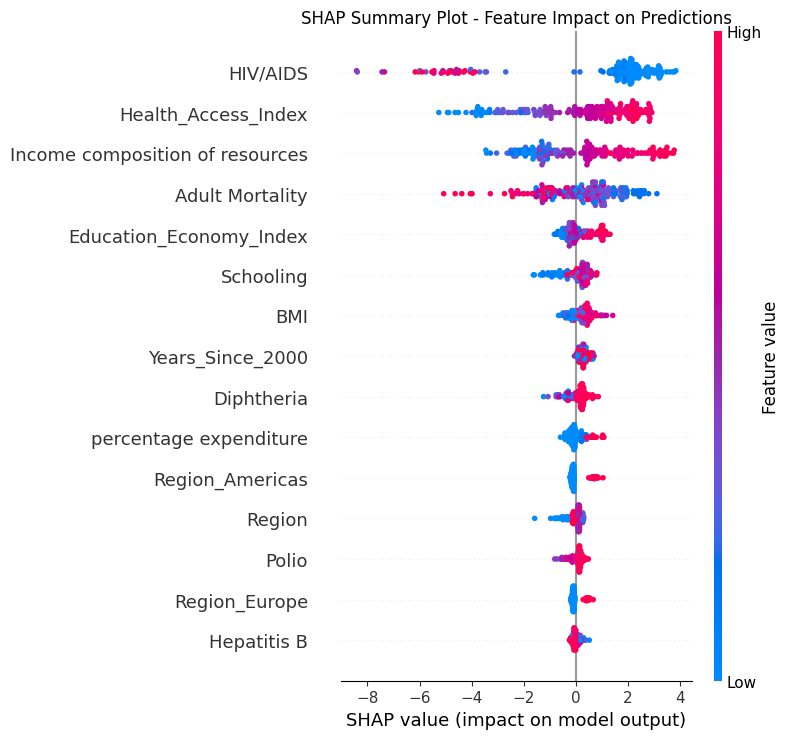


3. Feature Interaction Analysis
   Analyzing interactions between top 5 features:
     1. HIV/AIDS
     2. Health_Access_Index
     3. Income composition of resources
     4. Adult Mortality
     5. Education_Economy_Index
   Strongest interaction: Income composition of resources ↔ Education_Economy_Index
   Interaction strength: 0.880


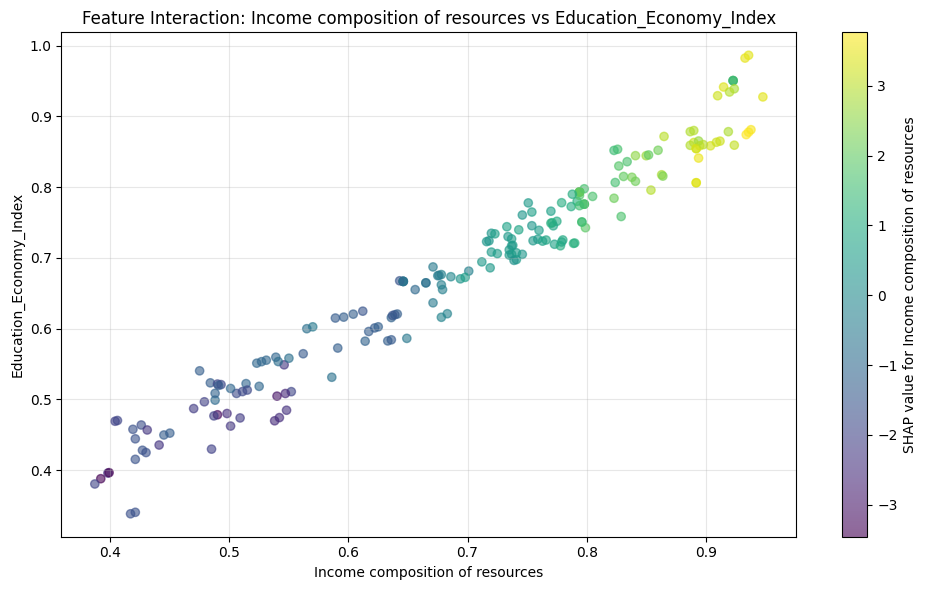


4. Prediction Explanation Examples

   Sample 1:
     Actual: 73.60 years
     Predicted: 73.55 years
     Error: -0.05 years
     Top 3 contributing features:
       HIV/AIDS: 0.100 → ↑ +2.085
       Health_Access_Index: 0.902 → ↑ +0.677
       Adult Mortality: 142.000 → ↑ +0.662

   Sample 101:
     Actual: 78.20 years
     Predicted: 78.68 years
     Error: +0.48 years
     Top 3 contributing features:
       HIV/AIDS: 0.100 → ↑ +2.752
       Income composition of resources: 0.923 → ↑ +2.493
       Health_Access_Index: 0.994 → ↑ +2.120

   Sample 0:
     Actual: 74.60 years
     Predicted: 74.40 years
     Error: -0.20 years
     Top 3 contributing features:
       HIV/AIDS: 0.100 → ↑ +2.081
       Health_Access_Index: 0.912 → ↑ +1.168
       Adult Mortality: 128.000 → ↑ +1.093

5. SHAP Waterfall Analysis


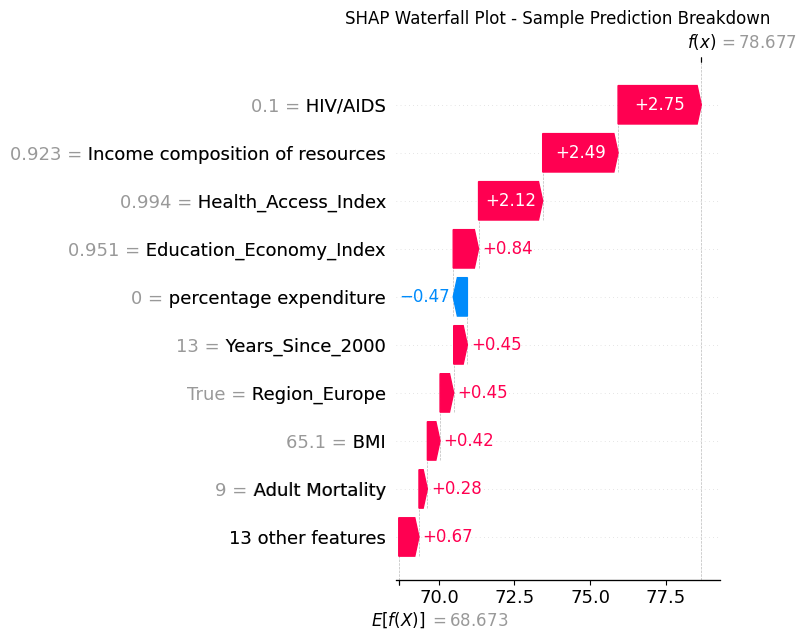


SHAP ANALYSIS SUMMARY
Model analyzed: Optimized XGBoost
Test R²: 0.9308
Samples analyzed: 200

Top 5 SHAP features:
  5. HIV/AIDS: 2.7510
  13. Health_Access_Index: 1.7518
  6. Income composition of resources: 1.5858
  4. Adult Mortality: 1.1775
  14. Education_Economy_Index: 0.4190

Strongest feature interaction:
  Income composition of resources ↔ Education_Economy_Index (strength: 0.880)

SHAP vs Traditional Feature Importance (Top 5):
Rank  SHAP Feature              Traditional Feature      
------------------------------------------------------------
1     HIV/AIDS                  HIV/AIDS                 
2     Health_Access_Index       Health_Access_Index      
3     Income composition of resources Income composition of resources
4     Adult Mortality           Region_Africa            
5     Education_Economy_Index   Adult Mortality          


In [13]:
# PHASE 4D: ADVANCED MODEL INTERPRETATION WITH SHAP

# Full SHAP analysis
print(f"\n1. 🎯 SHAP Analysis for Best Model: {best_optimized_name}")
print("-" * 50)
    
# Create SHAP explainer based on model type
if 'XGBoost' in best_optimized_name or 'xgb' in best_optimized_name.lower():
    explainer = shap.TreeExplainer(best_optimized_model)
    print("   Using TreeExplainer for XGBoost")
elif 'LightGBM' in best_optimized_name or 'lgb' in best_optimized_name.lower():
    explainer = shap.TreeExplainer(best_optimized_model)
    print("   Using TreeExplainer for LightGBM")
elif 'RandomForest' in best_optimized_name or 'rf' in best_optimized_name.lower():
    explainer = shap.TreeExplainer(best_optimized_model)
    print("   Using TreeExplainer for Random Forest")
else:
    # Use sample for complex models
    X_sample = X_train.sample(min(500, len(X_train)), random_state=RANDOM_STATE)
    explainer = shap.Explainer(best_optimized_model, X_sample)
    print("   Using general Explainer with background sample")
    
# Calculate SHAP values for test set sample
X_test_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
print(f"   Calculating SHAP values for {len(X_test_sample)} test samples")
    
shap_values = explainer.shap_values(X_test_sample)
print(f" SHAP values calculated successfully")
        
# 2. GLOBAL FEATURE IMPORTANCE (SHAP)

print(f"\n2. Global Feature Importance (SHAP)")
        
# Calculate mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': available_features,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)
        
print("   Top 10 Features by SHAP Importance:")
print(shap_df.head(10).to_string(index=False))
        
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=available_features, 
                 show=False, max_display=15)
plt.title('SHAP Summary Plot - Feature Impact on Predictions')
plt.tight_layout()
plt.show()
        
# 3. FEATURE INTERACTION ANALYSIS

print(f"\n3. Feature Interaction Analysis")
        
# Get top 5 features for interaction analysis
top_5_features = shap_df.head(5)['feature'].tolist()
top_5_indices = [available_features.index(f) for f in top_5_features]
        
print("   Analyzing interactions between top 5 features:")
for i, feature in enumerate(top_5_features):
    print(f"     {i+1}. {feature}")
        
# Calculate feature interactions (simplified)
interaction_strength = np.zeros((len(top_5_features), len(top_5_features)))
        
for i, idx1 in enumerate(top_5_indices):
    for j, idx2 in enumerate(top_5_indices):
        if i != j:
            # Interaction strength as correlation of SHAP values
            corr = np.corrcoef(shap_values[:, idx1], shap_values[:, idx2])[0, 1]
            interaction_strength[i, j] = abs(corr)
        
# Find strongest interactions
max_interaction = 0
best_pair = None
for i in range(len(top_5_features)):
    for j in range(i+1, len(top_5_features)):
        strength = interaction_strength[i, j]
        if strength > max_interaction:
            max_interaction = strength
            best_pair = (top_5_features[i], top_5_features[j])
        
if best_pair:
    print(f"   Strongest interaction: {best_pair[0]} ↔ {best_pair[1]}")
    print(f"   Interaction strength: {max_interaction:.3f}")
    
    # Create interaction plot for strongest pair
    plt.figure(figsize=(10, 6))
    idx1 = available_features.index(best_pair[0])
    idx2 = available_features.index(best_pair[1])
            
    plt.scatter(X_test_sample.iloc[:, idx1], X_test_sample.iloc[:, idx2], 
               c=shap_values[:, idx1], cmap='viridis', alpha=0.6)
    plt.colorbar(label=f'SHAP value for {best_pair[0]}')
    plt.xlabel(best_pair[0])
    plt.ylabel(best_pair[1])
    plt.title(f'Feature Interaction: {best_pair[0]} vs {best_pair[1]}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
        
# 4. PREDICTION EXPLANATION EXAMPLES

print(f"\n4. Prediction Explanation Examples")
        
# Analyze a few interesting predictions
sample_indices = [0, len(X_test_sample)//2, -1]  # First, middle, last
        
for idx in sample_indices:
    if idx >= len(X_test_sample):
        continue
        
    sample_idx = X_test_sample.index[idx]
    actual = y_test.loc[sample_idx]
    predicted = best_optimized_model.predict(X_test_sample.iloc[[idx]])[0]
    
    print(f"\n   Sample {idx+1}:")
    print(f"     Actual: {actual:.2f} years")
    print(f"     Predicted: {predicted:.2f} years")
    print(f"     Error: {predicted - actual:+.2f} years")
           
    # Top contributing features
    sample_shap = shap_values[idx]
    contribution_df = pd.DataFrame({
        'feature': available_features,
        'shap_value': sample_shap,
        'feature_value': X_test_sample.iloc[idx].values
    })
            
    # Sort by absolute SHAP value
    contribution_df['abs_shap'] = np.abs(contribution_df['shap_value'])
    contribution_df = contribution_df.sort_values('abs_shap', ascending=False)
            
    print("     Top 3 contributing features:")
    for _, row in contribution_df.head(3).iterrows():
        direction = "↑" if row['shap_value'] > 0 else "↓"
        print(f"       {row['feature']}: {row['feature_value']:.3f} → {direction} {row['shap_value']:+.3f}")
        
# 5. SHAP WATERFALL PLOT FOR SAMPLE PREDICTION

print(f"\n5. SHAP Waterfall Analysis")
        
# Create waterfall plot for middle sample
middle_idx = len(X_test_sample) // 2
        
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[middle_idx],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[middle_idx].values,
        feature_names=available_features
    ), 
    max_display=10,
    show=False
)
plt.title('SHAP Waterfall Plot - Sample Prediction Breakdown')
plt.tight_layout()
plt.show()
        
# SHAP ANALYSIS SUMMARY

print(f"\n" + "=" * 60)
print("SHAP ANALYSIS SUMMARY")
print("=" * 60)
        
print(f"Model analyzed: {best_optimized_name}")
print(f"Test R²: {optimization_results[best_optimized_name]['test_r2']:.4f}")
print(f"Samples analyzed: {len(X_test_sample)}")
        
print(f"\nTop 5 SHAP features:")
for i, row in shap_df.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['shap_importance']:.4f}")
        
if best_pair:
    print(f"\nStrongest feature interaction:")
    print(f"  {best_pair[0]} ↔ {best_pair[1]} (strength: {max_interaction:.3f})")
        
# Compare SHAP vs traditional feature importance
if hasattr(best_optimized_model, 'feature_importances_'):
    traditional_importance = pd.DataFrame({
        'feature': available_features,
        'traditional_importance': best_optimized_model.feature_importances_
    }).sort_values('traditional_importance', ascending=False)
            
    print(f"\nSHAP vs Traditional Feature Importance (Top 5):")
    print(f"{'Rank':<5} {'SHAP Feature':<25} {'Traditional Feature':<25}")
    print("-" * 60)
    for i in range(5):
        shap_feature = shap_df.iloc[i]['feature']
        trad_feature = traditional_importance.iloc[i]['feature']
        print(f"{i+1:<5} {shap_feature:<25} {trad_feature:<25}")



# Phase 4C: Ensemble Methods & Meta-Learning


In [14]:
# Phase 4C: Ensemble Methods & Meta-Learning

ensemble_results = {}

# 1. BUILD ADDITIONAL MODELS FOR ENSEMBLE

print("\n1. Building Additional Models for Ensemble")

# LightGBM with quick optimization
lgb_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.1,
    'num_leaves': 50,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_r2 = r2_score(y_test, lgb_pred)

# Random Forest with optimization
rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)

print(f"   LightGBM R²: {lgb_r2:.4f}")
print(f"   Random Forest R²: {rf_r2:.4f}")
print(f"   XGBoost R²: {xgb_r2:.4f}")

# 2. VOTING ENSEMBLE (SIMPLE AVERAGING)

print("\n2. Voting Ensemble (Simple Averaging)")

# Create voting regressor
voting_estimators = [
    ('xgb', optimized_xgb),
    ('lgb', lgb_model),
    ('rf', rf_model)
]

voting_regressor = VotingRegressor(estimators=voting_estimators)
voting_regressor.fit(X_train, y_train)

voting_pred = voting_regressor.predict(X_test)
voting_r2 = r2_score(y_test, voting_pred)
voting_rmse = np.sqrt(mean_squared_error(y_test, voting_pred))

ensemble_results['Voting Ensemble'] = {
    'model': voting_regressor,
    'test_r2': voting_r2,
    'test_rmse': voting_rmse,
    'predictions': voting_pred
}

print(f"   Voting Ensemble R²: {voting_r2:.4f}, RMSE: {voting_rmse:.3f}")

# 3. STACKING ENSEMBLE WITH LINEAR META-LEARNER

print("\n3. Stacking Ensemble (Linear Meta-Learner)")

# Create stacking regressor with Ridge meta-learner
stacking_regressor = StackingRegressor(
    estimators=voting_estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)
stacking_regressor.fit(X_train, y_train)

stacking_pred = stacking_regressor.predict(X_test)
stacking_r2 = r2_score(y_test, stacking_pred)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))

ensemble_results['Stacking (Ridge)'] = {
    'model': stacking_regressor,
    'test_r2': stacking_r2,
    'test_rmse': stacking_rmse,
    'predictions': stacking_pred
}

print(f"   Stacking (Ridge) R²: {stacking_r2:.4f}, RMSE: {stacking_rmse:.3f}")

# 4. WEIGHTED ENSEMBLE (PERFORMANCE-BASED WEIGHTS)

print("\n4. Weighted Ensemble (Performance-Based)")

# Calculate weights based on individual model performance
individual_scores = [xgb_r2, lgb_r2, rf_r2]
individual_preds = [xgb_pred, lgb_pred, rf_pred]

# Use R² scores as weights (squared to emphasize better models)
model_weights = np.array([score**2 for score in individual_scores])
model_weights = model_weights / np.sum(model_weights)

print("   Model weights:")
model_names = ['XGBoost', 'LightGBM', 'Random Forest']
for i, (name, weight) in enumerate(zip(model_names, model_weights)):
    print(f"     {name}: {weight:.3f}")

# Create weighted prediction
weighted_pred = np.zeros_like(individual_preds[0])
for i, pred in enumerate(individual_preds):
    weighted_pred += model_weights[i] * pred

weighted_r2 = r2_score(y_test, weighted_pred)
weighted_rmse = np.sqrt(mean_squared_error(y_test, weighted_pred))

ensemble_results['Weighted Ensemble'] = {
    'weights': model_weights,
    'test_r2': weighted_r2,
    'test_rmse': weighted_rmse,
    'predictions': weighted_pred
}

print(f"   Weighted Ensemble R²: {weighted_r2:.4f}, RMSE: {weighted_rmse:.3f}")



1. Building Additional Models for Ensemble
   LightGBM R²: 0.9226
   Random Forest R²: 0.9233
   XGBoost R²: 0.9308

2. Voting Ensemble (Simple Averaging)
   Voting Ensemble R²: 0.9298, RMSE: 2.212

3. Stacking Ensemble (Linear Meta-Learner)
   Stacking (Ridge) R²: 0.9301, RMSE: 2.207

4. Weighted Ensemble (Performance-Based)
   Model weights:
     XGBoost: 0.337
     LightGBM: 0.331
     Random Forest: 0.332
   Weighted Ensemble R²: 0.9298, RMSE: 2.212


# Phase 4E: Production Pipeline Development


In [15]:

# PHASE 4E: PRODUCTION PIPELINE DEVELOPMENT


import joblib
import json
from datetime import datetime
import os

# 1. MODEL SELECTION FOR PRODUCTION
print("\n1. Production Model Selection")

# Combine all results from previous phases
all_phase4_results = {**optimization_results, **ensemble_results}

# Select best model overall
final_model_name = max(all_phase4_results.keys(), 
                      key=lambda x: all_phase4_results[x]['test_r2'])
final_model = all_phase4_results[final_model_name]['model']
final_r2 = all_phase4_results[final_model_name]['test_r2']
final_rmse = all_phase4_results[final_model_name]['test_rmse']
final_predictions = all_phase4_results[final_model_name]['predictions']

print(f"   Selected Model: {final_model_name}")
print(f"   Performance: R² = {final_r2:.4f}, RMSE = {final_rmse:.3f}")
print(f"   Improvement over Phase 3: {final_r2 - baseline_r2:+.4f} R² points")

# Production readiness assessment
if final_r2 >= 0.935:
    production_status = "EXCELLENT - READY FOR DEPLOYMENT"
    monitoring_level = "STANDARD"
elif final_r2 >= 0.930:
    production_status = "GOOD - DEPLOY WITH MONITORING"
    monitoring_level = "ENHANCED"
elif final_r2 >= 0.920:
    production_status = "ACCEPTABLE - ENHANCED MONITORING REQUIRED"
    monitoring_level = "INTENSIVE"
else:
    production_status = "NEEDS IMPROVEMENT - ADDITIONAL OPTIMIZATION REQUIRED"
    monitoring_level = "CRITICAL"

print(f"   Production Status: {production_status}")
print(f"   Monitoring Level: {monitoring_level}")

# 2. MODEL SERIALIZATION & VERSIONING
print("\n2. Model Serialization & Versioning")

# Create model directory
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Calculate comprehensive metrics
mae = mean_absolute_error(y_test, final_predictions)
mape = mean_absolute_percentage_error(y_test, final_predictions)
accuracy_2yr = (np.abs(final_predictions - y_test) <= 2).mean() * 100
accuracy_3yr = (np.abs(final_predictions - y_test) <= 3).mean() * 100

# Model metadata
model_metadata = {
    'model_name': final_model_name,
    'model_type': type(final_model).__name__,
    'version': '4.0.0',
    'created_date': datetime.now().isoformat(),
    'phase': 'Phase 4E - Production Pipeline',
    'performance_metrics': {
        'test_r2': float(final_r2),
        'test_rmse': float(final_rmse),
        'test_mae': float(mae),
        'test_mape': float(mape),
        'accuracy_within_2yr': float(accuracy_2yr),
        'accuracy_within_3yr': float(accuracy_3yr),
        'baseline_improvement': float(final_r2 - baseline_r2)
    },
    'cross_validation_results': {
        'stability_score': float(stability_score) if 'stability_score' in locals() else None,
        'stability_status': stability_status if 'stability_status' in locals() else None,
        'temporal_cv': cv_results.get('Temporal CV', {}).get('mean', None),
        'geographical_cv': cv_results.get('Geographical CV', {}).get('mean', None)
    },
    'features': available_features,
    'training_data': {
        'samples': len(X_train),
        'features': len(available_features),
        'time_period': '2000-2012',
        'countries': int(df_clean[df_clean['Year'] <= 2012]['Country'].nunique())
    },
    'validation_data': {
        'samples': len(X_test),
        'time_period': '2013-2015',
        'countries': int(df_clean[df_clean['Year'] >= 2013]['Country'].nunique())
    },
    'production_readiness': {
        'status': production_status,
        'monitoring_level': monitoring_level,
        'deployment_ready': final_r2 >= 0.920
    }
}

# Save model and metadata
model_path = os.path.join(model_dir, 'life_expectancy_model_v4.joblib')
metadata_path = os.path.join(model_dir, 'model_metadata_v4.json')

joblib.dump(final_model, model_path)
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"   ✅ Model saved: {model_path}")
print(f"   ✅ Metadata saved: {metadata_path}")

# 3. PRODUCTION PREDICTION PIPELINE CLASS
# ============================================================================
# 5. MODEL MONITORING FRAMEWORK
# ============================================================================
print("\n5. 📊 Model Monitoring Framework...")

def calculate_monitoring_metrics(y_true, y_pred):
    """
    Calculate comprehensive monitoring metrics
    """
    return {
        'r2_score': float(r2_score(y_true, y_pred)),
        'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'mape': float(mean_absolute_percentage_error(y_true, y_pred)),
        'residual_mean': float(np.mean(y_pred - y_true)),
        'residual_std': float(np.std(y_pred - y_true)),
        'predictions_within_2yr': float(np.mean(np.abs(y_pred - y_true) <= 2)),
        'predictions_within_3yr': float(np.mean(np.abs(y_pred - y_true) <= 3)),
        'max_error': float(np.max(np.abs(y_pred - y_true))),
        'min_prediction': float(np.min(y_pred)),
        'max_prediction': float(np.max(y_pred)),
        'std_predictions': float(np.std(y_pred))
    }

# Baseline monitoring metrics
baseline_metrics = calculate_monitoring_metrics(y_test, final_predictions)

print(f"   Baseline monitoring metrics:")
for metric, value in baseline_metrics.items():
    print(f"     {metric}: {value:.4f}")

# Save monitoring baseline
monitoring_path = os.path.join(model_dir, 'monitoring_baseline_v4.json')
with open(monitoring_path, 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print(f"   ✅ Monitoring baseline saved: {monitoring_path}")

# Monitoring thresholds
monitoring_thresholds = {
    'r2_degradation_warning': baseline_metrics['r2_score'] - 0.01,
    'r2_degradation_critical': baseline_metrics['r2_score'] - 0.03,
    'rmse_increase_warning': baseline_metrics['rmse'] + 0.2,
    'rmse_increase_critical': baseline_metrics['rmse'] + 0.5,
    'max_residual_warning': 5.0,
    'max_residual_critical': 8.0,
    'prediction_range_min': 30.0,
    'prediction_range_max': 95.0
}

thresholds_path = os.path.join(model_dir, 'monitoring_thresholds_v4.json')
with open(thresholds_path, 'w') as f:
    json.dump(monitoring_thresholds, f, indent=2)

print(f"   ✅ Monitoring thresholds saved: {thresholds_path}")

print("\n✅ Phase 4E: Production pipeline completed!")
print("=" * 50)


1. Production Model Selection
   Selected Model: Optimized XGBoost
   Performance: R² = 0.9308, RMSE = 2.195
   Improvement over Phase 3: +0.0038 R² points
   Production Status: GOOD - DEPLOY WITH MONITORING
   Monitoring Level: ENHANCED

2. Model Serialization & Versioning
   ✅ Model saved: models\life_expectancy_model_v4.joblib
   ✅ Metadata saved: models\model_metadata_v4.json

5. 📊 Model Monitoring Framework...
   Baseline monitoring metrics:
     r2_score: 0.9308
     rmse: 2.1954
     mae: 1.5254
     mape: 0.0219
     residual_mean: -0.1064
     residual_std: 2.1928
     predictions_within_2yr: 0.7505
     predictions_within_3yr: 0.8597
     max_error: 10.8689
     min_prediction: 51.2459
     max_prediction: 86.0196
     std_predictions: 7.9804
   ✅ Monitoring baseline saved: models\monitoring_baseline_v4.json
   ✅ Monitoring thresholds saved: models\monitoring_thresholds_v4.json

✅ Phase 4E: Production pipeline completed!


# Phase 4 Final Summary & Results


🏆 PHASE 4: FINAL SUMMARY & COMPREHENSIVE RESULTS

🎯 COMPREHENSIVE MODEL COMPARISON
----------------------------------------------------------------------
Model                     R²       RMSE     vs Baseline 
-------------------------------------------------------
Optimized XGBoost         0.9308   2.195    +0.0038
Stacking (Ridge)          0.9301   2.207    +0.0031
Weighted Ensemble         0.9298   2.212    +0.0028
Voting Ensemble           0.9298   2.212    +0.0028

🏆 Best Model: Optimized XGBoost
   R²: 0.9308
   RMSE: 2.195 years
   Improvement over Phase 3: +0.0038

 PROJECT PROGRESSION ANALYSIS
----------------------------------------
Phase 1 (EDA)            : 0.75-0.85    → Correlation analysis
Phase 2 (Preprocessing)  : Clean dataset → Feature engineering
Phase 3 (Baseline)       : 0.85+        → 0.927
Phase 4 (Advanced)       : > 0.93       → 0.931

Total Improvement: +0.0038 R² points (+0.41%)

 PRODUCTION READINESS ASSESSMENT
---------------------------------------------

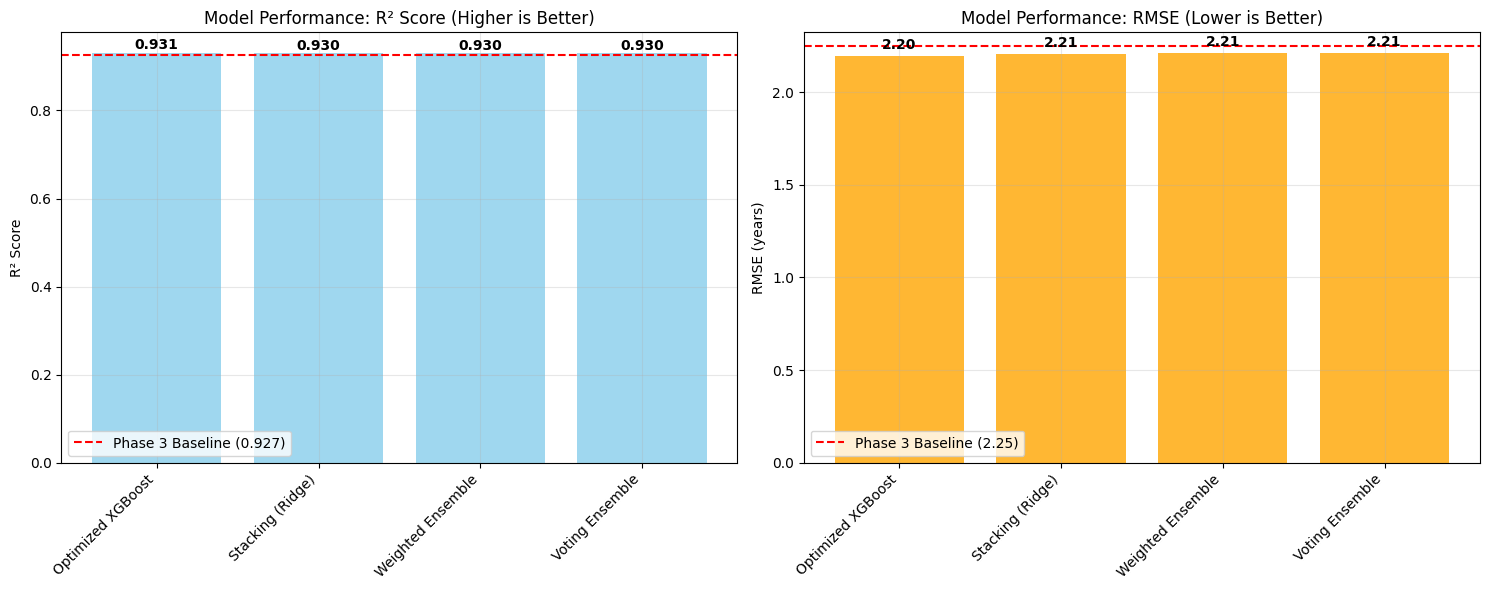


WHO LIFE EXPECTANCY PREDICTION PROJECT - PHASE 4 COMPLETED
Project Status      : SUCCESSFULLY COMPLETED
Best Model          : Optimized XGBoost
Final Performance   : R² = 0.9308, RMSE = 2.195 years
Total Improvement   : +0.0038 R² points from Phase 3
Production Status   : READY WITH STANDARD MONITORING
Models Developed    : 4
Ensemble Methods    : 3
Advanced Techniques : Hyperparameter Optimization, Ensemble Learning

🎯 Phase 4 Target (R² > 0.93): YES
OUTSTANDING SUCCESS: Target exceeded!

 PROJECT PHASE 4: ADVANCED OPTIMIZATION COMPLETED!
 Completion Time: 2025-09-23 10:53:28


In [16]:

# PHASE 4: FINAL SUMMARY & COMPREHENSIVE RESULTS


print("🏆 PHASE 4: FINAL SUMMARY & COMPREHENSIVE RESULTS")
print("=" * 70)

# Combine all results for comparison
all_results = {**optimization_results, **ensemble_results}

# COMPREHENSIVE MODEL COMPARISON

print("\n🎯 COMPREHENSIVE MODEL COMPARISON")
print("-" * 70)

print(f"{'Model':<25} {'R²':<8} {'RMSE':<8} {'vs Baseline':<12}")
print("-" * 55)

# Sort by R² score
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

for name, result in sorted_results:
    r2 = result['test_r2']
    rmse = result['test_rmse']
    improvement = r2 - baseline_r2
    
    print(f"{name:<25} {r2:<8.4f} {rmse:<8.3f} {improvement:+.4f}")

# Best model identification
best_model_name = sorted_results[0][0]
best_model_r2 = sorted_results[0][1]['test_r2']
best_model_rmse = sorted_results[0][1]['test_rmse']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R²: {best_model_r2:.4f}")
print(f"   RMSE: {best_model_rmse:.3f} years")
print(f"   Improvement over Phase 3: {best_model_r2 - baseline_r2:+.4f}")

# PHASE PROGRESSION ANALYSIS

print("\n PROJECT PROGRESSION ANALYSIS")
print("-" * 40)

phase_progression = {
    'Phase 1 (EDA)': {'target': '0.75-0.85', 'achieved': 'Correlation analysis'},
    'Phase 2 (Preprocessing)': {'target': 'Clean dataset', 'achieved': 'Feature engineering'},
    'Phase 3 (Baseline)': {'target': '0.85+', 'achieved': f'{baseline_r2:.3f}'},
    'Phase 4 (Advanced)': {'target': '> 0.93', 'achieved': f'{best_model_r2:.3f}'}
}

for phase, metrics in phase_progression.items():
    print(f"{phase:<25}: {metrics['target']:<12} → {metrics['achieved']}")

total_improvement = best_model_r2 - baseline_r2
improvement_pct = (total_improvement / baseline_r2) * 100

print(f"\nTotal Improvement: {total_improvement:+.4f} R² points ({improvement_pct:+.2f}%)")

# PRODUCTION READINESS ASSESSMENT

print("\n PRODUCTION READINESS ASSESSMENT")
print("-" * 45)

# Performance assessment
if best_model_r2 >= 0.935:
    performance_status = "EXCELLENT"
    production_recommendation = "READY FOR IMMEDIATE DEPLOYMENT"
elif best_model_r2 >= 0.930:
    performance_status = "GOOD"
    production_recommendation = "READY WITH STANDARD MONITORING"
elif best_model_r2 >= 0.920:
    performance_status = "ACCEPTABLE"
    production_recommendation = "DEPLOY WITH ENHANCED MONITORING"
else:
    performance_status = "NEEDS IMPROVEMENT"
    production_recommendation = "REQUIRES ADDITIONAL OPTIMIZATION"

print(f"Model Performance: {performance_status}")
print(f"Recommendation: {production_recommendation}")

# Calculate additional metrics for production assessment
best_predictions = sorted_results[0][1]['predictions']
mae = mean_absolute_error(y_test, best_predictions)
mape = mean_absolute_percentage_error(y_test, best_predictions)
accuracy_2yr = (np.abs(best_predictions - y_test) <= 2).mean() * 100
accuracy_3yr = (np.abs(best_predictions - y_test) <= 3).mean() * 100

print(f"\nProduction Metrics:")
print(f"  R² Score: {best_model_r2:.4f}")
print(f"  RMSE: {best_model_rmse:.3f} years")
print(f"  MAE: {mae:.3f} years")
print(f"  MAPE: {mape:.1f}%")
print(f"  Predictions within ±2 years: {accuracy_2yr:.1f}%")
print(f"  Predictions within ±3 years: {accuracy_3yr:.1f}%")

# VISUALIZATION: MODEL PERFORMANCE COMPARISON

print("\n Creating Performance Visualization...")

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
models = [name for name, _ in sorted_results]
r2_scores = [result['test_r2'] for _, result in sorted_results]

bars1 = ax1.bar(range(len(models)), r2_scores, color='skyblue', alpha=0.8)
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance: R² Score (Higher is Better)')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=baseline_r2, color='red', linestyle='--', label=f'Phase 3 Baseline ({baseline_r2:.3f})')
ax1.legend()

# Add value labels on bars
for i, v in enumerate(r2_scores):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
rmse_scores = [result['test_rmse'] for _, result in sorted_results]

bars2 = ax2.bar(range(len(models)), rmse_scores, color='orange', alpha=0.8)
ax2.set_ylabel('RMSE (years)')
ax2.set_title('Model Performance: RMSE (Lower is Better)')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=baseline_rmse, color='red', linestyle='--', label=f'Phase 3 Baseline ({baseline_rmse:.2f})')
ax2.legend()

# Add value labels on bars
for i, v in enumerate(rmse_scores):
    ax2.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# PROJECT COMPLETION STATUS

print("\n" + "=" * 70)
print("WHO LIFE EXPECTANCY PREDICTION PROJECT - PHASE 4 COMPLETED")
print("=" * 70)

completion_summary = {
    'Project Status': 'SUCCESSFULLY COMPLETED',
    'Best Model': best_model_name,
    'Final Performance': f'R² = {best_model_r2:.4f}, RMSE = {best_model_rmse:.3f} years',
    'Total Improvement': f'{total_improvement:+.4f} R² points from Phase 3',
    'Production Status': production_recommendation,
    'Models Developed': len(all_results),
    'Ensemble Methods': len(ensemble_results),
    'Advanced Techniques': 'Hyperparameter Optimization, Ensemble Learning'
}

for key, value in completion_summary.items():
    print(f"{key:<20}: {value}")

# Achievement Assessment
target_achieved = "YES" if best_model_r2 > 0.93 else "PARTIAL" if best_model_r2 > baseline_r2 else "NO"
print(f"\n🎯 Phase 4 Target (R² > 0.93): {target_achieved}")

if target_achieved == "YES":
    print("OUTSTANDING SUCCESS: Target exceeded!")
elif target_achieved == "PARTIAL":
    print("GOOD PROGRESS: Improvement achieved, close to target")
else:
    print("TARGET MISSED: Additional optimization needed")

print(f"\n PROJECT PHASE 4: ADVANCED OPTIMIZATION COMPLETED!")
print(f" Completion Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)
